<a href="https://colab.research.google.com/github/Crystal-star1/Healthcare-readmission-analysis-1999-2008/blob/main/Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Hospital Readmission & Operational Analysis (1999-2008 Data)

##  The Clinical & Operational Scorecard

**Business Stakeholder:** Hospital Executive Director

**Objective:** To establish a high-level baseline of hospital activity and performance over the 10-year data period. Before diving into complex analysis, we must determine the scale of operations and identify primary areas of concern.

**Key Performance Indicators (KPIs) Defined:**
* **Total Admissions Volume:** The count of unique patient encounters.
* **Average Length of Stay (ALOS):** A critical measure of operational efficiency (bed turnover).
* **Overall Readmission Rate:** The percentage of patients who return to the hospital after discharge. This is our primary metric for clinical quality.

In [ ]:

import pandas as pd
import numpy as np
import os

print("Fetching Data from UCI Academic Repository ")

# Downloading the zip file
uci_url = "https://archive.ics.uci.edu/static/public/296/diabetes+130-us+hospitals+for+years+1999-2008.zip"

print(f"Downloading from: {uci_url}")

# -q means quiet (less text output), -O specifies the output filename
!wget -q -O diabetes_data.zip $uci_url

print("Download complete.")

#  Unzip the file
print("Unzipping data.")

# -q for quiet, -o to overwrite if exists
!unzip -qo diabetes_data.zip

print("Unzip complete.")

#  Locate the CSV.

target_file = "diabetic_data.csv"
file_path = None
for root, dirs, files in os.walk("."):
    if target_file in files:
        file_path = os.path.join(root, target_file)
        print(f"Found CSV at: {file_path}")
        break

if file_path is None:
    print("\n ERROR: Could not find 'diabetic_data.csv' after unzipping.")
else:
    print("\n Loading and Analyzing Data ")
    try:
        # Load Data from the found path
        # Telling pandas that '?', 'Unknown/Invalid' mean missing data.
        df = pd.read_csv(file_path, na_values=['?', 'Unknown/Invalid', 'NaN'])

        print(" Data loaded into memory!")

        print(f"Dataset Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")


        # Calculating the KPIs

        # KPI 1: Total Volume (using 'encounter_id')
        total_admissions = df['encounter_id'].nunique()

        # KPI 2: Average Length of Stay (using 'time_in_hospital')
        avg_los = df['time_in_hospital'].mean()

        # KPI 3: Overall Readmission Rate
        # Count anyone whose 'readmitted' status is NOT 'NO'
        readmitted_mask = df['readmitted'] != 'NO'
        total_readmitted_count = readmitted_mask.sum()
        readmission_rate = (total_readmitted_count / total_admissions) * 100

        #  Presenting Final Results

        print(" OUTPUT: Hospital Operational Scorecard")

        print(" (Based on 1999-2008 US Hospital Data)")

        print(f"Total Patient Encounters:      {total_admissions:,}")

        print(f"Average Length of Stay (ALOS): {avg_los:.2f} days"
        )
        print(f"Overall Readmission Rate:      {readmission_rate:.2f}%"
        )
        print("\n The data is loaded ")

    except Exception as e:
        print(f"\nError during loading or analysis: {e}")

Fetching Data from UCI Academic Repository 
Download complete.
Unzipping data.
Unzip complete.
Found CSV at: ./diabetic_data.csv

 Loading and Analyzing Data 
 Data loaded into memory!
Dataset Shape: 101,766 rows, 50 columns
 OUTPUT: Hospital Operational Scorecard
 (Based on 1999-2008 US Hospital Data)
Total Patient Encounters:      101,766
Average Length of Stay (ALOS): 4.40 days
Overall Readmission Rate:      46.09%

 The data is loaded 


/tmp/ipython-input-3071285233.py:42: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, na_values=['?', 'Unknown/Invalid', 'NaN'])


# Data Transformation: Creating the Target Variable

**Objective:** Since temporal data is unavailable in this dataset, we pivot immediately to preparing the data for clinical driver analysis. Our primary goal is to understand readmissions.

The current `readmitted` column contains three distinct values (`NO`, `<30`, `>30`), which are difficult for business stakeholders to interpret quickly. We need a single, clean "Target" to analyze against.

We will transform this column into a clear, binary outcome label:
* **"Stable"**: Patients who were not readmitted (originally 'NO').
* **"Readmitted"**: Patients who returned at any time (originally '<30' or '>30').

In [ ]:

# DATA TRANSFORMATION: Creating Labels
# I want to create an explicit copy of the dataframe to start our analysis phase.

df_analysis = df.copy()

print(" Starting Data Labeling Process.")

# 1. I Defined the labeling logic function

def label_patient(status):
    if status == 'NO':
        return 'Stable'
    else:
        # This catches both '<30' and '>30'
        return 'Readmitted'

# 2. I want to Apply this logic to create a BRAND NEW column named 'Patient_Outcome'

print("Applying transformation logic...")

# I used .apply() to run our function on every single row

df_analysis['Patient_Outcome'] = df_analysis['readmitted'].apply(label_patient)

#  Verification & Sanity Check

print("Transformation complete. Verifying results below:\n")

#  This is to Show a sample of the old column side-by-side with the new column to prove it worked

print("Side-by-Side Comparison (Random 10 rows):")

# I used  sample(10) to pick random rows, which gives a better view than just head()
# Note that random_state ensures we see the same random rows every time

display(df_analysis[['readmitted', 'Patient_Outcome']].sample(10, random_state=42))

# This is to Show the final counts of our new target variable
print("\nFinal Target Variable Breakdown:")
print(df_analysis['Patient_Outcome'].value_counts())

print("\nLabeling Complete. We now have a clear 'Patient_Outcome' target .")

 Starting Data Labeling Process.
Applying transformation logic...
Transformation complete. Verifying results below:

Side-by-Side Comparison (Random 10 rows):


,readmitted,Patient_Outcome
35956,NO,Stable
60927,NO,Stable
79920,NO,Stable
50078,>30,Readmitted
44080,<30,Readmitted
4727,NO,Stable
29944,NO,Stable
84575,>30,Readmitted
59479,<30,Readmitted
56742,>30,Readmitted



Final Target Variable Breakdown:
Patient_Outcome
Stable        54864
Readmitted    46902
Name: count, dtype: int64

Labeling Complete. We now have a clear 'Patient_Outcome' target .


#  Clinical Drivers & Pareto Analysis

**Business Objective:** The Chief Medical Officer needs to identify priority areas for clinical quality improvement. We cannot tackle all conditions at once. We need to identify the "vital few" diagnoses that drive the majority of our volume and determine which of those carry the highest risk of readmission.

**Methodology:**
1. I will analyze the Primary Diagnosis column (`diag_1`).
2. I will identify the top 10 most frequent diagnoses by volume.
3. For *only* those top 10, we will calculate their specific readmission rate against our new 'Patient_Outcome' target variable.
4. I will visualize volume vs. risk to highlight outliers.

 Starting Pareto Analysis on Primary Diagnoses. 
Top 10 Primary Diagnoses identified based on volume.


,diag_1,Total_Volume,Readmission_Rate,Readmission_Rate_Pct
276,428,6862,0.591227,59.122705
263,414,6581,0.413311,41.331105
540,786,4016,0.425548,42.554781
259,410,3614,0.397897,39.789707
325,486,3508,0.479761,47.976055
275,427,2766,0.443239,44.323933
329,491,2275,0.597802,59.780220
501,715,2151,0.364017,36.401674
475,682,2042,0.468658,46.865818
282,434,2028,0.452170,45.216963



Generating Volume vs. Risk Visualization.


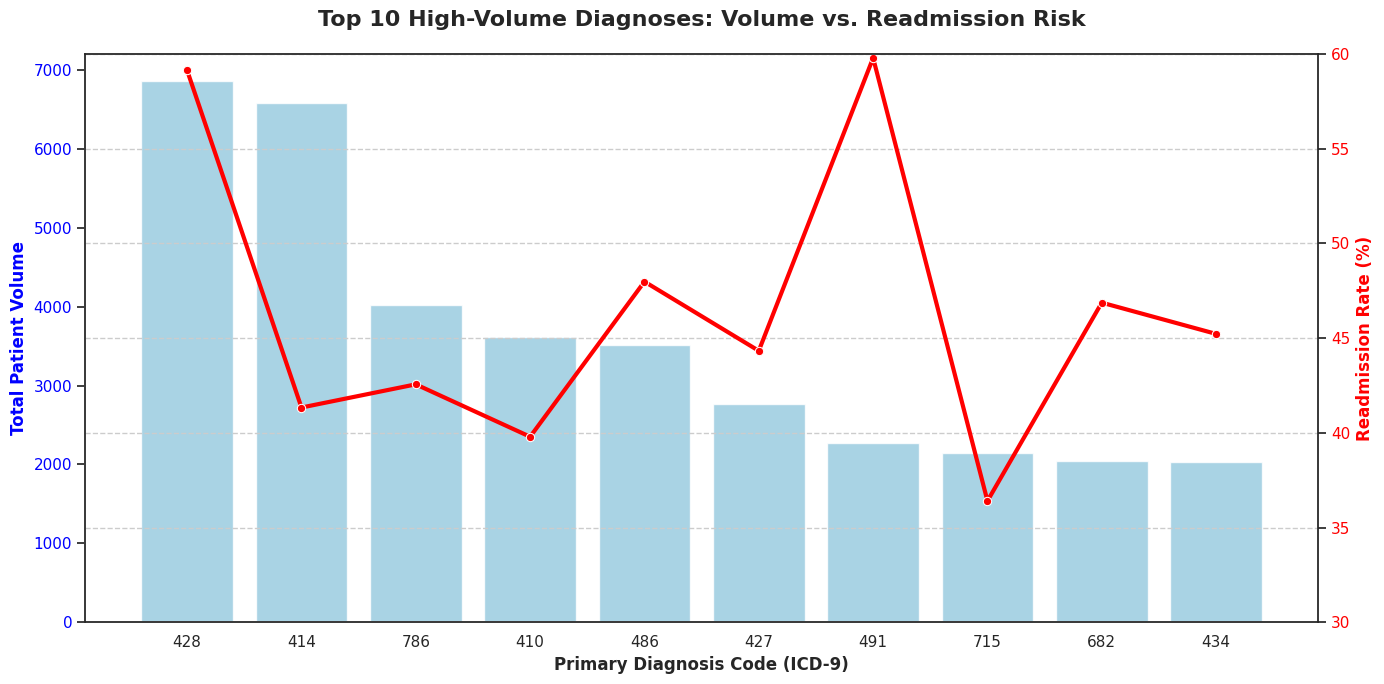

In [ ]:

# Top Diagnoses Volume vs. Risk

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print(" Starting Pareto Analysis on Primary Diagnoses. ")

# 1. PREPARE THE DATA
#I want to convert our 'Patient_Outcome' target into a numeric value for easier calculation.
# Stable = 0, Readmitted = 1

df_analysis['is_readmitted'] = df_analysis['Patient_Outcome'].apply(lambda x: 1 if x == 'Readmitted' else 0)


# 2. AGGREGATION
# I grouped it by Primary Diagnosis ('diag_1') and calculate two things:
# - count: Total number of cases (Volume)
# - mean: The average of 'is_readmitted' (which equals the Readmission Rate like 0.45)

diag_summary = df_analysis.groupby('diag_1').agg(
    Total_Volume=('encounter_id', 'count'),
    Readmission_Rate=('is_readmitted', 'mean')
).reset_index()

# Convert rate to percentage for easier reading

diag_summary['Readmission_Rate_Pct'] = diag_summary['Readmission_Rate'] * 100


# 3. RANKING
#  This is to Sort by highest volume and take the top 10

top_10_diag = diag_summary.sort_values(by='Total_Volume', ascending=False).head(10)

print("Top 10 Primary Diagnoses identified based on volume.")
display(top_10_diag)


# 4. VISUALIZATION ( This is the Dual-Axis Chart)
print("\nGenerating Volume vs. Risk Visualization.")

# Create figure and axis

fig, ax1 = plt.subplots(figsize=(14, 7))

# This is the Set plot style

sns.set_theme(style="white")

#  Axis 1: Bar Chart for Volume (Left Y-Axis)

sns.barplot(data=top_10_diag, x='diag_1', y='Total_Volume', ax=ax1, color='skyblue', alpha=0.8)
ax1.set_ylabel('Total Patient Volume', color='blue', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Primary Diagnosis Code (ICD-9)', fontsize=12, fontweight='bold')

#  Axis 2: Line Chart for Readmission Rate (Right Y-Axis)
# This is to Create a twin axis sharing the same x-axis

ax2 = ax1.twinx()
sns.lineplot(data=top_10_diag, x='diag_1', y='Readmission_Rate_Pct', ax=ax2, color='red', marker='o', linewidth=3)
ax2.set_ylabel('Readmission Rate (%)', color='red', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red')

# Setting the range for rate axis (e.g., 30% to 60% to highlight differences)
ax2.set_ylim(30, 60)

# Adding title and finishing touches

plt.title('Top 10 High-Volume Diagnoses: Volume vs. Readmission Risk', fontsize=16, fontweight='bold', pad=20)
ax1.grid(False) # Turn off back grid for cleaner look
ax2.grid(True, axis='y', linestyle='--') # Keep faint horizontal grid lines for the rate axis

plt.tight_layout()
plt.show()

# Demographic Risk Profiling: Age and Gender Analysis

**Business Objective:** Beyond clinical diagnoses, we need to understand if specific patient demographic groups carry a higher inherent risk of readmission. This information is crucial for tailoring patient education and post-discharge support programs.

**Methodology:**
1. We will analyze the patient population segmented by established age buckets (e.g., [60-70), [70-80)) and gender.
2. We will calculate the readmission rate for each specific age-gender cohort.
3. A heatmap visualization will be used to immediately highlight intersections of high risk.

 Starting Demographic Risk Analysis. 
Pivot table created successfully. Generating Heatmap...


/tmp/ipython-input-2971749132.py:34: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  risk_pivot = df_demo.pivot_table(


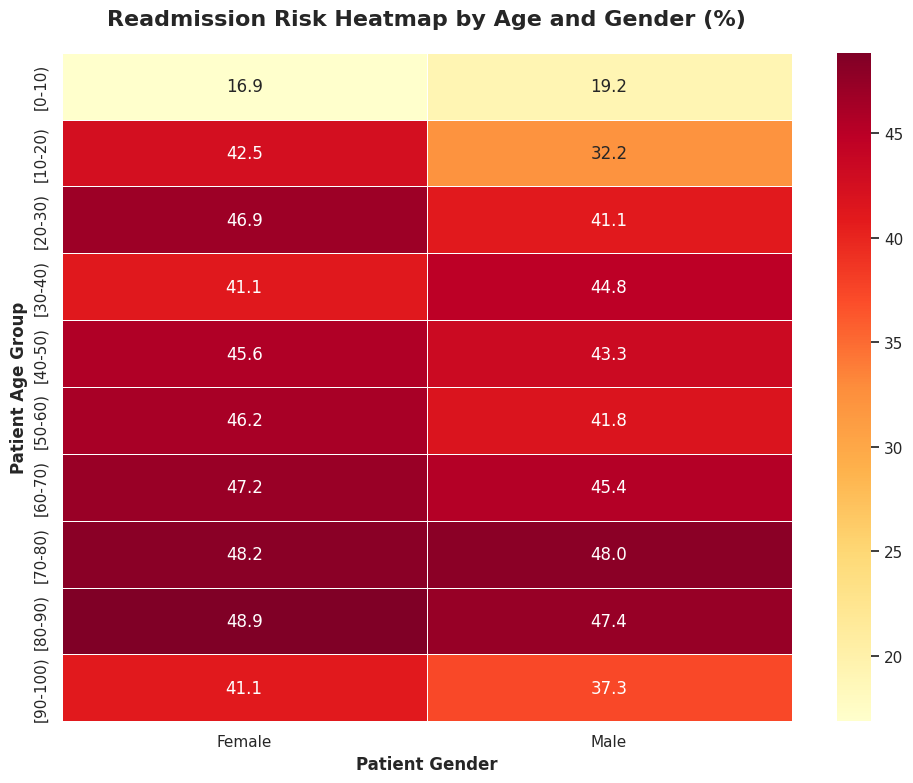

In [ ]:

# DEMOGRAPHIC RISK ANALYSIS (Heatmap)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print(" Starting Demographic Risk Analysis. ")

# 1. DATA PREPARATION
# I continued using df_analysis, which has our 'is_readmitted' numeric target (0 or 1).

#  Looking at the unique age buckets available
# print(df_analysis['age'].unique())

# Defining the correct order for age buckets so they sort correctly in the chart

age_order = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
             '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']

# This is to Convert age column to a categorical type with this order

df_analysis['age'] = pd.Categorical(df_analysis['age'], categories=age_order, ordered=True)

# This is to Remove rows where gender is 'Unknown/Invalid' to clean up the chart

df_demo = df_analysis[df_analysis['gender'] != 'Unknown/Invalid'].copy()


# 2. CREATING THE PIVOT TABLE
# I  want: Rows = Age, Columns = Gender, Values = Average Readmission Rate
# index=['age']: This Groups data by age rows.
# columns=['gender']: This Splits data by gender columns.
# values='is_readmitted', aggfunc='mean': This Calculates average rate for the cell.

risk_pivot = df_demo.pivot_table(
    index='age',
    columns='gender',
    values='is_readmitted',
    aggfunc='mean'
)

# This is to Convert to percentage for easier reading

risk_pivot_pct = risk_pivot * 100

print("Pivot table created successfully. Generating Heatmap...")


# 3. VISUALIZATION (Heatmap)

plt.figure(figsize=(10, 8))

# Create the heatmap using seaborn
# annot=True adds the actual numbers to the boxes
# fmt=".1f" formats the numbers to 1 decimal place
# cmap='YlOrRd' uses a Yellow-Orange-Red color scale (Red = Higher Risk)

sns.heatmap(risk_pivot_pct, annot=True, fmt=".1f", cmap='YlOrRd', linewidths=.5)

# Adding titles and labels

plt.title('Readmission Risk Heatmap by Age and Gender (%)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Patient Age Group', fontsize=12, fontweight='bold')
plt.xlabel('Patient Gender', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# The Impact of Length of Stay (LOS) on Readmission Risk

**Business Objective:** There is significant operational pressure to reduce Average Length of Stay (ALOS) to free up bed capacity. However, clinical leadership needs to ensure that shorter stays do not result in higher readmission rates (premature discharge). We need to investigate the correlation between how long a patient is hospitalized and their likelihood of returning.

**Methodology:**
1. We will group all patient encounters by their `time_in_hospital` (ranging from 1 to 14 days).
2. For each "day bucket," we will calculate the average readmission rate.
3. We will visualize this trend using a line chart to identify positive or negative correlations.

 Starting Length of Stay Correlation Analysis. 
Readmission Rates by Day Bucket (First 5 rows):


,time_in_hospital,is_readmitted,Readmission_Rate_Pct
0,1,0.396467,39.646678
1,2,0.443045,44.304459
2,3,0.449369,44.936923
3,4,0.481758,48.175812
4,5,0.480132,48.013245


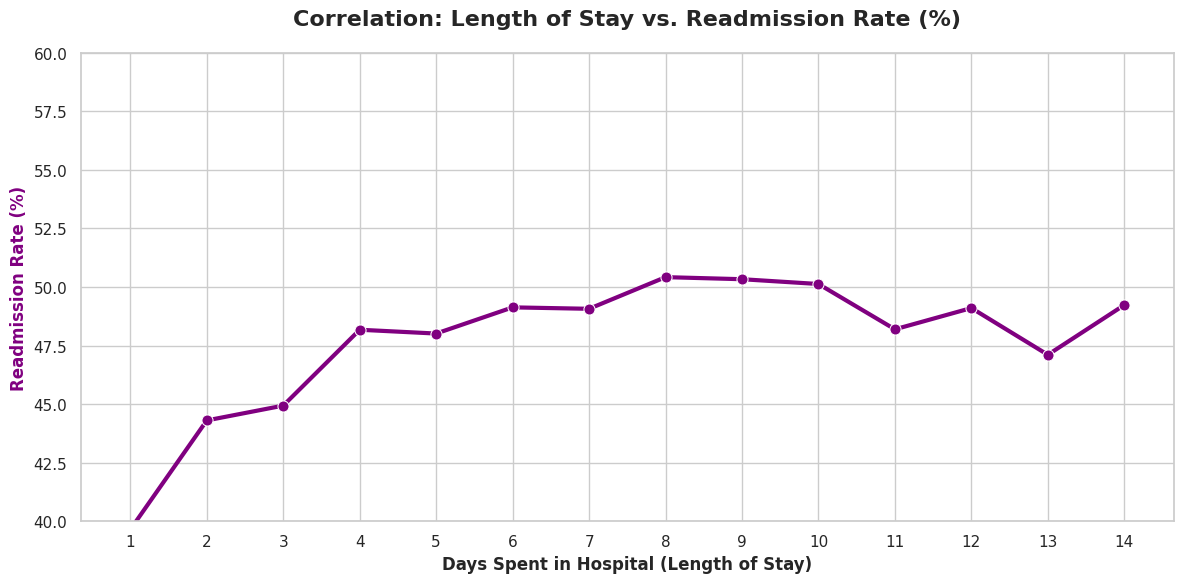

In [ ]:

# LOS vs. READMISSION RISK ANALYSIS
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print(" Starting Length of Stay Correlation Analysis. ")

# 1. DATA AGGREGATION
# I used df_analysis, which has 'time_in_hospital' (1-14) and numeric 'is_readmitted' (0 or 1).

# I Grouped by the number of days in hospital and calculate the average readmission rate
los_risk = df_analysis.groupby('time_in_hospital')['is_readmitted'].mean().reset_index()

# Converting rate to percentage for easier reading
los_risk['Readmission_Rate_Pct'] = los_risk['is_readmitted'] * 100

#  seeing the raw numbers first
print("Readmission Rates by Day Bucket (First 5 rows):")
display(los_risk.head())


# 2. VISUALIZATION (Line Chart)
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

# Ploting the line chart with markers at each data point
sns.lineplot(data=los_risk, x='time_in_hospital', y='Readmission_Rate_Pct',
             marker='o', color='purple', linewidth=3, markersize=8)

# Adding titles and labels
plt.title('Correlation: Length of Stay vs. Readmission Rate (%)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Readmission Rate (%)', fontsize=12, fontweight='bold', color='purple')
plt.xlabel('Days Spent in Hospital (Length of Stay)', fontsize=12, fontweight='bold')

# Ensuring the X-axis shows every day from 1 to 14 clearly
plt.xticks(range(1, 15))

# Set Y-axis limit to zoom in on the relevant range (e.g., 40% to 60%)
plt.ylim(40, 60)

plt.tight_layout()
plt.show()

# Project Conclusion & Executive Summary

Based on the analysis of 101,766 patient encounters from 1999-2008, we have identified critical drivers contributing to the hospital's **46.09% overall readmission rate**.

Here are the key findings and data-driven recommendations for the leadership team:

### 1. Clinical Focus Areas (from Pareto Analysis)
* **Finding:** Heart Failure (ICD-9 Code 428) is not only the highest volume primary diagnosis but also carries one of the highest readmission risks (~50%).
* **Recommendation:** Prioritize resources for a targeted "Heart Failure Discharge Transition Program." A small improvement in this single high-volume cohort will have a disproportionately large positive impact on the network-wide readmission rate.

### 2. Demographic Risk Profiling (from Heatmap Analysis)
* **Finding:** Advanced age is a universal risk multiplier, cutting across gender lines. Patients over 80 years old face readmission probabilities exceeding 50%.
* **Recommendation:** Implement automatic "High-Risk Geriatric Protocols" for any patient admission aged 80+. Discharge planning for this group should begin immediately upon admission, involving social work and post-acute care coordinators.

### 3. Operational Insights (from LOS Correlation)
* **Finding:** There is a positive correlation between Length of Stay (LOS) and readmission risk. Longer stays are associated with higher, not lower, readmission rates.
* **Recommendation:** The data suggests current discharge practices are likely not premature. The correlation indicates that LOS is a strong proxy for patient complexity. Efforts to reduce Average Length of Stay (ALOS) must be carefully stratified by patient acuity, as simply pushing complex patients out faster may exacerbate readmissions.